<a href="https://colab.research.google.com/github/Mo-JR-92/CIFAR10-with-Resnet-arch/blob/main/resnet9-arch-CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('project-cifar100-classification')
jovian.set_colab_id('1mwpxAhhiEA122P_YF1oK6oYmvuASE8fE')

# Project-Classifiying CIFAR100 images using ResNets, Regularization and Data Augmentation in PyTorch

Use the "Run" button to execute the code.

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import numpy as np


from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.transforms as tt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name='project-cifar100-classification'

### Preparing the CIFAR100 Dataset
we are going to use the CIFAR100 class in torchvision.datasets to download the data, the train argument is set to True by default and that will download the training dataset if download is set to True, and by changing train to False we can download the test dataset.

In [ ]:
from torchvision.datasets import CIFAR100
# Downloading the trianing data into data folder
dataset = CIFAR100(root='data/', train=True, download=True)
# Downloading the test data into data folder
test_dataset = CIFAR100(root='data/', train=False, download=True)
classes = dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(dataset), len(test_dataset), len(classes)

(50000, 10000, 100)

Label: 17 - castle


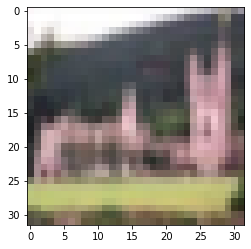

In [ ]:
img, label = dataset[31]
plt.imshow(img)
print(f'Label: {label} - {classes[label]}')

Label: 71 - sea


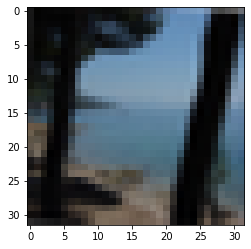

In [ ]:
img, label = test_dataset[10]
plt.imshow(img)
print(f'Label: {label} - {classes[label]}')

In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip, RandomRotation
# Data transforms (normalization & data augmentation)
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
dataset_tfms = tt.Compose([tt.RandomCrop(32, padding=2, padding_mode='reflect'),
                           tt.RandomHorizontalFlip(),
                          #  tt.RandomRotation(15),
                           tt.ToTensor(),
                           tt.Normalize(*stats, inplace=True)])
test_tfms = tt.Compose([tt.Resize((32, 32)),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])

In [ ]:
# Transforming the training and testing datasets
t_dataset = CIFAR100(root='data/', train=True, download=True, transform=dataset_tfms)
t_test_dataset = CIFAR100(root='data/', train=False, download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 17 - castle


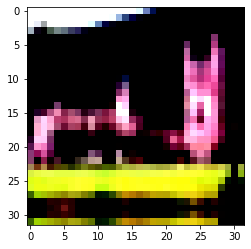

In [ ]:
img, label = t_dataset[31]
plt.imshow(img.permute((1, 2, 0)))
print(f'Label: {label} - {classes[label]}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 84 - table


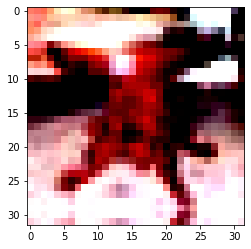

In [ ]:
img, label = t_dataset[571]
plt.imshow(img.permute((1, 2, 0)))
print(f'Label: {label} - {classes[label]}')

Instead of spliting the training data to training and validation we are going to use the test dataset as the validation data in the training process, this can help us boost the accuracy of our model by a small margin, we will not be able to test the model after training so the validation accuracy will by the metric we can use to evaluate the model.

In [ ]:
# setting the manual seed and creating validation , training, batch sizes
torch.manual_seed(43)

batch_size = 256

Creating the train_loader and the val_loader using DataLoader


In [ ]:
# Pytorch data Loaders
train_loader = DataLoader(t_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(t_test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- The denormalize function will denormalize the pixels values to bring them back into the range (0,1).
- while the show_batch will display 64 images from one batch of images after denormalize the pixels.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


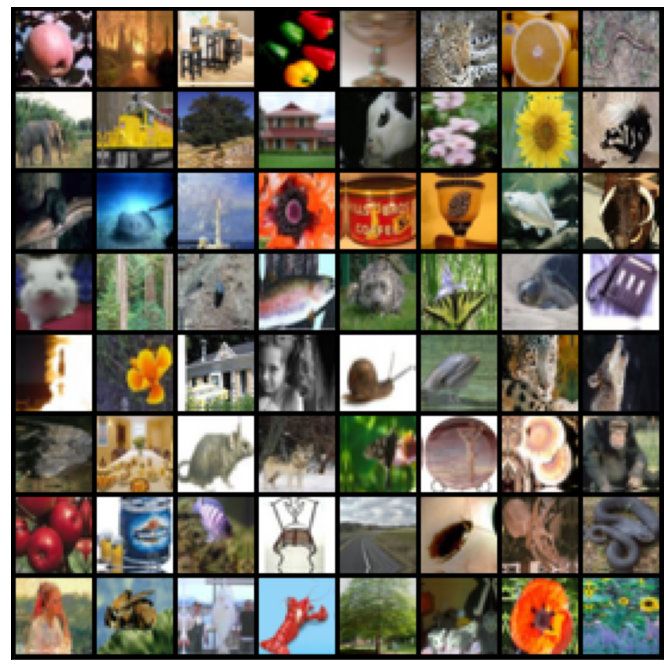

In [ ]:
show_batch(train_loader)

### Using GPU
- The next two function will help us use GPU if one is available get_default_device will do exactuly that, and to_device will help us move tensors to the chosing device
- The class DeviceDataLoader will help us move the train and validate data loaders to the device.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device, torch.cuda.is_available()

(device(type='cuda'), True)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

### Model with Residual Blocks and Batch Normalization
In December 2015, Kaiming He and coauthors presented residual networks [(ResNet)](https://arxiv.org/abs/1512.03385), an architecture that uses a simple trick to allow very deep networks to be successfully trained. That work opened the door to networks ranging from tens of layers to 100 layers in depth, surpassing the then state of the art in computer vision benchmark problems.

source : Deep Learning with PyTorch book chapter 8, 5.3 Going deeper to learn more complex structures: Depth


- Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Resudial block adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
               nn.BatchNorm2d(out_channels),
               nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.res1(out) + out

      out = self.conv3(out)
      out = self.conv4(out)
      out = self.res2(out) + out

      out = self.classifier(out)
      return out

In [ ]:
model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # Gradient Clipping
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.011109834536910057, 'val_loss': 4.6071600914001465}]

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 100])
out[0]: tensor([ 7.2816e-02,  1.2699e-01,  6.6767e-02, -9.0850e-02, -4.8910e-02,
         5.9686e-02, -7.4567e-02, -6.6691e-02, -8.4393e-02, -7.6091e-02,
         8.1759e-02,  5.7994e-02, -2.6256e-02, -7.0595e-02, -7.5283e-02,
        -3.7182e-02,  8.2866e-02,  6.2680e-02,  1.0899e-01,  2.6942e-02,
         1.0804e-02, -4.8416e-02,  1.1189e-02,  3.9032e-02,  6.2001e-03,
        -3.3191e-02,  4.8876e-02, -5.2958e-02, -2.3783e-02,  1.4811e-03,
         9.9327e-02, -4.4966e-02, -4.6823e-03, -2.0314e-02, -5.4885e-02,
         1.2693e-02, -6.9223e-02,  2.9729e-02,  1.0299e-01,  1.8359e-02,
        -2.5058e-02,  2.7349e-02,  4.5471e-02,  4.9833e-02,  4.7269e-02,
         3.0758e-02, -3.8499e-02, -6.2347e-03,  6.0354e-02,  1.4537e-02,
        -7.8128e-02,  2.6997e-02, -7.2383e-02, -3.2169e-04, -1.0028e-01,
         4.1911e-02,  2.8244e-02,  4.9592e-03, -4.1053e-02, -1.1205e-01,
        -4.1294e-02, -1.1696e-01,  1.28

Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers [here](https://ruder.io/optimizing-gradient-descent/index.html)

In [ ]:
epochs = 20
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00052, train_loss: 3.8655, val_loss: 3.2556, val_acc: 0.2099
Epoch [1], last_lr: 0.00140, train_loss: 3.0241, val_loss: 2.9492, val_acc: 0.2832
Epoch [2], last_lr: 0.00260, train_loss: 2.5802, val_loss: 2.6823, val_acc: 0.3242
Epoch [3], last_lr: 0.00380, train_loss: 2.2453, val_loss: 2.8215, val_acc: 0.3156
Epoch [4], last_lr: 0.00468, train_loss: 1.9240, val_loss: 2.2968, val_acc: 0.4129
Epoch [5], last_lr: 0.00500, train_loss: 1.6904, val_loss: 1.9612, val_acc: 0.4838
Epoch [6], last_lr: 0.00494, train_loss: 1.5134, val_loss: 2.2301, val_acc: 0.4345
Epoch [7], last_lr: 0.00475, train_loss: 1.3773, val_loss: 1.6237, val_acc: 0.5513
Epoch [8], last_lr: 0.00445, train_loss: 1.2656, val_loss: 1.6092, val_acc: 0.5559
Epoch [9], last_lr: 0.00406, train_loss: 1.1805, val_loss: 1.5370, val_acc: 0.5777
Epoch [10], last_lr: 0.00358, train_loss: 1.0848, val_loss: 1.4730, val_acc: 0.6033
Epoch [11], last_lr: 0.00306, train_loss: 0.9869, val_loss: 1.4868, val_acc: 0.6064
Ep

In [ ]:
train_time = '9:03'

### Ploting The History

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

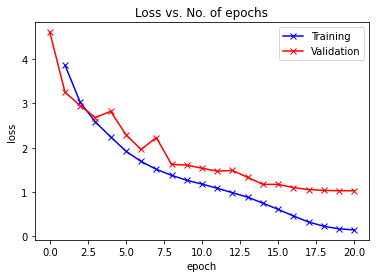

In [ ]:
plot_losses(history)

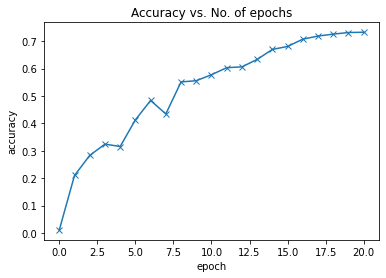

In [ ]:
plot_accuracies(history)

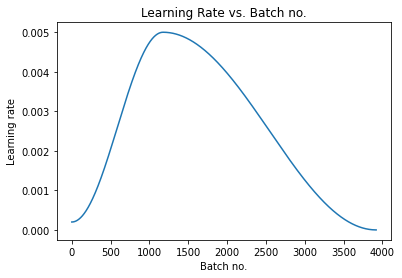

In [ ]:
plot_lrs(history)

### Testing on Random Images

In [ ]:
import random as r

In [ ]:
# this function will take an image and the model and will predict the iamge.
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
# This function will display some info about the image blus the image itself
# every time you run it will test on a random image.
def show_predicted_image():
    idx = r.randint(0, 9999)
    img, label = t_test_dataset[idx]
    plt.imshow(img.permute((1, 2, 0)))
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
    print(f'Image index: {idx}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bicycle , Predicted: bicycle
Image index: 5855


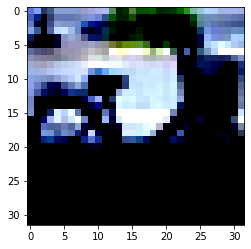

In [ ]:
show_predicted_image()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: telephone , Predicted: telephone
Image index: 4837


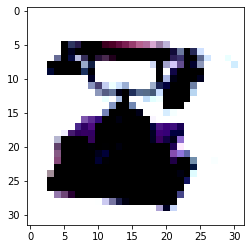

In [ ]:
show_predicted_image()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: lawn_mower , Predicted: lawn_mower
Image index: 4741


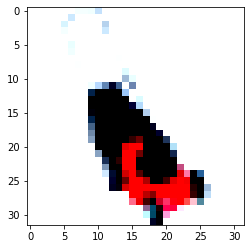

In [ ]:
show_predicted_image()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: mouse , Predicted: mouse
Image index: 8156


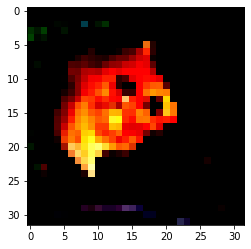

In [ ]:
show_predicted_image()

### Conclusions 

- In this project we have used ResNet architecture to create CNN model and trained this model on CIFAR100 dataset.
- The model achieved 73% Accuracy on the validation set, This result can be improved further by making the model deeper or choosing different data augmantation techniques, or expermenting with the hyperparameters.
- However achieving high accuracy was not the goal of this notebook, the goal was to understand and implement the architecture in [ResNet](https://arxiv.org/abs/1512.03385) Paper by Kaiming He.
- This was the final project in Deep Learning with PyTorch: Zero to GANs by [Jovian](https://jovian.ai/), mostly the code snippets was done by Jovain with some changes I made to test on this dataset.

#### Save and Commint

In [ ]:
torch.save(model.state_dict(), 'project-cifar100-resnet9-classification.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs,
                       batch_size=batch_size, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project=project_name, environment=None, outputs=['project-cifar100-resnet9-classification.pth'])


[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/joem8737/project-cifar100-classification


'https://jovian.ai/joem8737/project-cifar100-classification'